In [1]:
import pandas as pd
import numpy as np
import re
import json
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
filename = 'marketing_sample_for_indeed_usa-indeed_usa_job__20210101_20210331__30k_data.ldjson'
df = pd.read_json(filename, lines=True)

CPU times: total: 3.05 s
Wall time: 5.06 s


In [3]:
df

,uniq_id,crawl_timestamp,url,job_title,category,company_name,city,state,country,post_date,...,dataset,is_remote,postdate_in_indexname_format,segment_name,fitness_score,inferred_salary_from,inferred_salary_to,inferred_salary_time_unit,inferred_salary_currency,salary_offered
0,fbc64e47c636a36486de369e39100ba9,2021-02-17 09:05:02 +0000,https://www.indeed.com/viewjob?jk=290155a0362e...,Proposal Coordinator - Security Detection and ...,Administrative,Leidos,Reston,VA,US,2021-02-17,...,[job_board],false,2021.02.11,indeed_usa_com_job_board_common_setup_pc_jobsp...,10,NaN,NaN,NaN,NaN,NaN
1,959a7778077259539d88d36a63ee77aa,2021-03-03 10:15:39 +0000,https://www.indeed.com/viewjob?jk=24bb906c8e8c...,Quality Assurance (QA) Engineer,Computer-or-internet,Vantage Bank Texas,San Antonio,TX,US,2021-03-03,...,[job_board],false,2021.03.01,indeed_usa_com_job_board_common_setup_pc_jobsp...,10,NaN,NaN,NaN,NaN,NaN
2,4ef50bb5d04209cb530865627b7e7b39,2021-02-06 06:11:45 +0000,https://www.indeed.com/viewjob?jk=34a37ce921be...,Project Manager,Upper-Management-or-consulting,Cognizant Technology Solutions,San Antonio,TX,US,2021-02-06,...,[job_board],false,2021.02.01,indeed_usa_com_job_board_common_setup_pc_jobsp...,10,NaN,NaN,NaN,NaN,NaN
3,0e995706ddd2fd642c7ec384c251449b,2021-03-05 16:15:38 +0000,https://www.indeed.com/viewjob?jk=e82e749f1a21...,Entry Level Site / Civil Engineer,Engineering-or-architecture,Dewberry,Charlotte,NC,US,2021-03-05,...,[job_board],false,2021.03.01,indeed_usa_com_job_board_common_setup_pc_jobsp...,10,NaN,NaN,NaN,NaN,NaN
4,135f776d2853f47d13a1c93292e08820,2021-02-27 03:31:00 +0000,https://www.indeed.com/viewjob?jk=f28222500014...,Territory Office Manager- San Diego,Sales,Colonial Life,San Diego,CA,US,2021-02-27,...,[job_board],true,2021.02.22,indeed_usa_com_job_board_common_setup_pc_jobsp...,10,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29959,7eb8fc5cd7a3237d81634c329b87a989,2021-03-04 01:57:45 +0000,https://www.indeed.com/viewjob?jk=a27fbc716324...,Salesperson/Driver,Sales,Advance Auto Parts,Cedar Rapids,IA,US,2021-03-04,...,[job_board],false,2021.03.01,indeed_usa_com_job_board_common_setup_pc_jobsp...,10,NaN,NaN,NaN,NaN,NaN
29960,c2aa6805e0e6b2c3ab29a53dd9119884,2021-01-06 10:44:44 +0000,https://www.indeed.com/viewjob?jk=dcfac6cd8aca...,Patient Coordinator,Healthcare,Peak Dental Services LLC,Colorado Springs,CO,US,2021-01-06,...,[job_board],false,2021.01.01,NaN,10,NaN,NaN,NaN,USD,NaN
29961,4ea3db0a0901ce507377adc96b52533b,2021-02-09 22:55:42 +0000,https://www.indeed.com/viewjob?jk=996c5e0ea504...,Intern,Non-profit/volunteering,Rockwell Development Center,Huntersville,NC,US,2021-02-09,...,[job_board],false,2021.02.01,indeed_usa_com_job_board_common_setup_pc_jobsp...,10,NaN,NaN,NaN,NaN,NaN
29962,f99987fe33252e58762893b854dbd7fc,2021-01-11 10:59:42 +0000,https://www.indeed.com/viewjob?jk=94e804b8d1ae...,News - Producer - WCJB,Healthcare,Gray Television,Gainesville,FL,US,2021-01-11,...,[job_board],false,2021.01.11,indeed_usa_com_job_board_common_setup_pc_jobsp...,10,NaN,NaN,NaN,USD,NaN


In [4]:
missing = df.isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / len(df)) * 100
missing.index = missing['features']
missing.drop('features', axis=1, inplace=True)
missing = missing[missing['percent'] > 0]
missing

,total_missing,percent
features,,
state,1022,3.410760
apply_url,17939,59.868509
company_description,14318,47.784007
test_contact_email,28306,94.466693
contact_email,28306,94.466693
test1_states,1022,3.410760
inferred_city,1680,5.606728
inferred_state,514,1.715392
segment_name,1141,3.807903


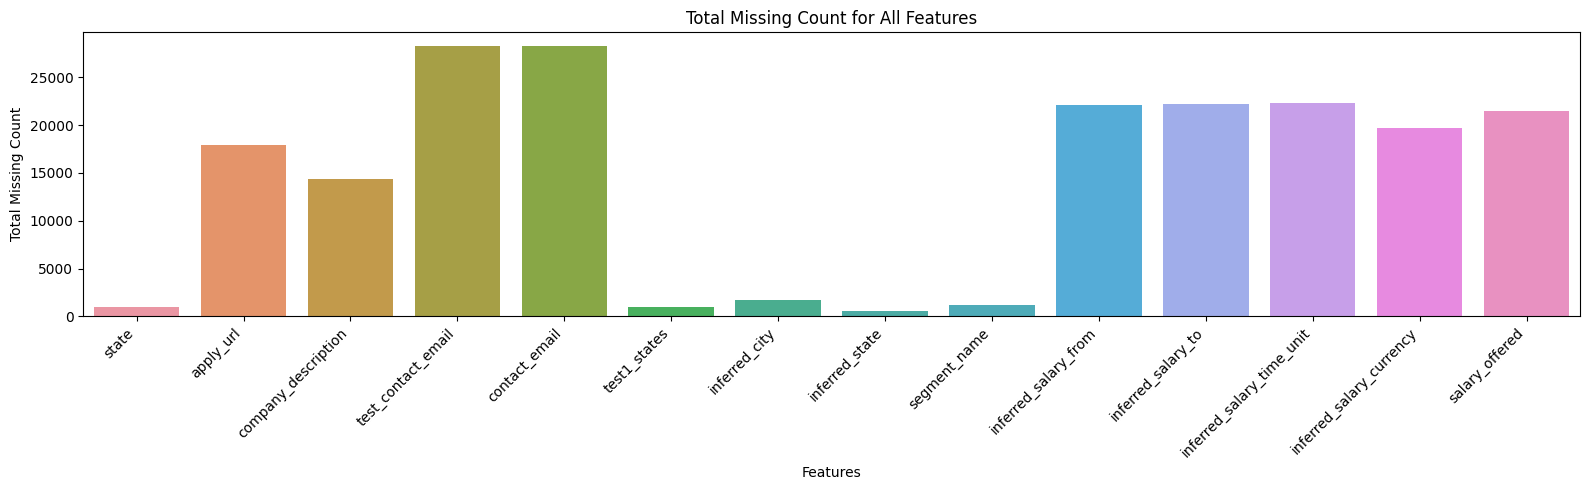

In [5]:
plt.figure(figsize=(16, 5))
ax = sns.barplot(x=missing.index, y='total_missing', data=missing)
plt.title('Total Missing Count for All Features')
plt.xlabel('Features')
plt.ylabel('Total Missing Count')

# Rotate the xtick labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [6]:
features = ['uniq_id', 'url', 'job_title', 'category',
       'company_name','job_description', 'company_description', 'job_type',
       'predicted_language']
df = df[features]

# Drop rows with empty Company Description
df = df.dropna()
# Drop rows with Job Desciption containing the word "Company Description" (not relevant)
df = df[~df['job_description'].str.contains('Company Description')] 
df.shape

(15401, 9)

In [7]:
df.head()

,uniq_id,url,job_title,category,company_name,job_description,company_description,job_type,predicted_language
0,fbc64e47c636a36486de369e39100ba9,https://www.indeed.com/viewjob?jk=290155a0362e...,Proposal Coordinator - Security Detection and ...,Administrative,Leidos,Description Job Description: The Proposal Coor...,Leidos Leidos is a Fortune 500® information te...,Contract,en
1,959a7778077259539d88d36a63ee77aa,https://www.indeed.com/viewjob?jk=24bb906c8e8c...,Quality Assurance (QA) Engineer,Computer-or-internet,Vantage Bank Texas,Description: JOB CLASSIFICATION Full / Part-ti...,Vantage Bank Texas was founded in 1923 and is ...,Part-time,en
2,4ef50bb5d04209cb530865627b7e7b39,https://www.indeed.com/viewjob?jk=34a37ce921be...,Project Manager,Upper-Management-or-consulting,Cognizant Technology Solutions,Principal Product Consultant Qualification : S...,Cognizant (NASDAQ-100: CTSH) is one of the wor...,Full-time,en
4,135f776d2853f47d13a1c93292e08820,https://www.indeed.com/viewjob?jk=f28222500014...,Territory Office Manager- San Diego,Sales,Colonial Life,Job Posting End Date: March 25 Unum is a compa...,"In 1937, Edwin F. Averyt and J. Clifton Judy s...",Full-time,en
7,f8af3b96087d5963ce1123b681596428,https://www.indeed.com/viewjob?jk=cbd007315e9d...,Fielded Supplier Quality Engineering Manager,Engineering-or-architecture,Raytheon Missiles & Defense,Businesses Raytheon Missiles & Defense Clearan...,"With facilities in Broughton, Waddington, Glen...",Temporary,en


In [8]:
df['predicted_language'].value_counts()

predicted_language
en    15391
es        9
fi        1
Name: count, dtype: int64

In [9]:
# Drop rows with language other than English
df = df[df['predicted_language'] == 'en']
df = df.drop('predicted_language', axis=1)
df.shape

(15391, 8)

In [10]:
# Drop duplicated values
df = df.drop_duplicates(['job_title', 'category', 'job_description'])
df.shape

(15331, 8)

In [11]:
# Join all relevant features into column 'texts'
df['texts'] =  df['category'] + ' ' + df['job_title'] + ' ' + df['job_description']
df.head()

,uniq_id,url,job_title,category,company_name,job_description,company_description,job_type,texts
0,fbc64e47c636a36486de369e39100ba9,https://www.indeed.com/viewjob?jk=290155a0362e...,Proposal Coordinator - Security Detection and ...,Administrative,Leidos,Description Job Description: The Proposal Coor...,Leidos Leidos is a Fortune 500® information te...,Contract,Administrative Proposal Coordinator - Security...
1,959a7778077259539d88d36a63ee77aa,https://www.indeed.com/viewjob?jk=24bb906c8e8c...,Quality Assurance (QA) Engineer,Computer-or-internet,Vantage Bank Texas,Description: JOB CLASSIFICATION Full / Part-ti...,Vantage Bank Texas was founded in 1923 and is ...,Part-time,Computer-or-internet Quality Assurance (QA) En...
2,4ef50bb5d04209cb530865627b7e7b39,https://www.indeed.com/viewjob?jk=34a37ce921be...,Project Manager,Upper-Management-or-consulting,Cognizant Technology Solutions,Principal Product Consultant Qualification : S...,Cognizant (NASDAQ-100: CTSH) is one of the wor...,Full-time,Upper-Management-or-consulting Project Manager...
4,135f776d2853f47d13a1c93292e08820,https://www.indeed.com/viewjob?jk=f28222500014...,Territory Office Manager- San Diego,Sales,Colonial Life,Job Posting End Date: March 25 Unum is a compa...,"In 1937, Edwin F. Averyt and J. Clifton Judy s...",Full-time,Sales Territory Office Manager- San Diego Job ...
7,f8af3b96087d5963ce1123b681596428,https://www.indeed.com/viewjob?jk=cbd007315e9d...,Fielded Supplier Quality Engineering Manager,Engineering-or-architecture,Raytheon Missiles & Defense,Businesses Raytheon Missiles & Defense Clearan...,"With facilities in Broughton, Waddington, Glen...",Temporary,Engineering-or-architecture Fielded Supplier Q...


In [158]:
df.to_csv('cleaned.csv')

In [12]:
df = pd.read_csv('cleaned.csv')
# We only use the texts for bulding the recommender
train_features = ['uniq_id', 'texts']
df2 = df[train_features]
df2

,uniq_id,texts
0,fbc64e47c636a36486de369e39100ba9,Administrative Proposal Coordinator - Security...
1,959a7778077259539d88d36a63ee77aa,Computer-or-internet Quality Assurance (QA) En...
2,4ef50bb5d04209cb530865627b7e7b39,Upper-Management-or-consulting Project Manager...
4,135f776d2853f47d13a1c93292e08820,Sales Territory Office Manager- San Diego Job ...
7,f8af3b96087d5963ce1123b681596428,Engineering-or-architecture Fielded Supplier Q...
...,...,...
29951,c3a3ec03bb112f5ac7d4a83ec4a5a665,Healthcare Unit Secretary - Atrium Health Unio...
29954,fc51b5ecd71019422ba269a8ea66ad43,Sales Territory Sales Representative - Greensb...
29958,c6ff492be2336115e2ef446483570dc0,Sales Sales Associate JOB TITLE: Sales Associa...
29959,7eb8fc5cd7a3237d81634c329b87a989,Sales Salesperson/Driver We are an Equal Oppor...


In [89]:
# Text preprocessing using regex and spacy
nlp = spacy.load('en_core_web_sm')
# Define unwanted words to be removed
unwanted_words = ['job', 'summary', 'work', 'description', 'company', 'overview', 'location', 'about', 'types',
                    'parttime', 'fulltime', 'contract', 'commission', 'weekday', 'date', 'post', 'end', 'hour', 'week', 'shift',
                    'paid', 'life', 'insurance', 'pay', 'retirement', 'schedule', 'equal', 'opportunity', 'employer',
                    'benefit', 'condition', 'wait', 'period', 'apply', 'employee', 'eligible',
                    'remotely', 'classification', 'qualification', 'post', 'currently']
# Define POS tag for words to be keeped
keep_pos = {'PROPN', 'ADJ', 'NOUN', 'VERB', 'ADV'}
# Define a list of entity types to keep
keep_ents = ['PERSON', 'ORG', 'FAC', 'PRODUCT', 'WORK_OF_ART']

def text_preprocess(text):
    # Tokenize the text
    doc = nlp(text)
    # Remove unwanted named entities
    for ent in doc.ents:
        if ent.label_ not in keep_ents:
            text = text[:ent.start_char] + ' '*(ent.end_char - ent.start_char) + text[ent.end_char:]
    # Remove or in text
    if '-or-' in text:
        text = text.replace('-or-', ' ')
    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans("", "", string.punctuation)).lower()
    # Remove website name
    text = re.sub(r'http\S+', '',text)
    # Remove digit
    text = re.sub('[0-9]+', '', text)
    # Normalize the spacing between words
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the cleaned text
    doc = nlp(text)
    # Remove stop words and return the remaining tokens and remove duplicate tokens
    tokens = {token.lemma_ for token in doc if token.text not in STOP_WORDS and token.lemma_ not in unwanted_words and token.pos_ in keep_pos and len(token.text) > 1}
    return list(tokens)

In [ ]:
df_pre = df2.copy()
df_pre['texts_preprocessed'] = df_pre['texts'].apply(text_preprocess)
df_pre['texts_pre_str'] = df_pre['texts_preprocessed'].apply(lambda x: ' '.join(x))
df_pre.to_csv('preprocessed.csv')

In [95]:
df_pre = pd.read_csv('preprocessed.csv')
df_pre = df_pre[['uniq_id', 'texts_pre_str']]
df_combined = pd.merge(df, df_pre, on='uniq_id')
df_combined = df_combined[['uniq_id', 'url', 'job_title', 'category', 'company_name',
                            'job_description', 'company_description', 'job_type', 'texts_pre_str']]
df_combined

,uniq_id,url,job_title,category,company_name,job_description,company_description,job_type,texts_pre_str
0,fbc64e47c636a36486de369e39100ba9,https://www.indeed.com/viewjob?jk=290155a0362e...,Proposal Coordinator - Security Detection and ...,Administrative,Leidos,Description Job Description: The Proposal Coor...,Leidos Leidos is a Fortune 500® information te...,Contract,headquarter fortune support sharepoint wwwleid...
1,959a7778077259539d88d36a63ee77aa,https://www.indeed.com/viewjob?jk=24bb906c8e8c...,Quality Assurance (QA) Engineer,Computer-or-internet,Vantage Bank Texas,Description: JOB CLASSIFICATION Full / Part-ti...,Vantage Bank Texas was founded in 1923 and is ...,Part-time,ownership internet scenario test grow meet ass...
2,4ef50bb5d04209cb530865627b7e7b39,https://www.indeed.com/viewjob?jk=34a37ce921be...,Project Manager,Upper-Management-or-consulting,Cognizant Technology Solutions,Principal Product Consultant Qualification : S...,Cognizant (NASDAQ-100: CTSH) is one of the wor...,Full-time,parameter headquarter fortune support business...
3,135f776d2853f47d13a1c93292e08820,https://www.indeed.com/viewjob?jk=f28222500014...,Territory Office Manager- San Diego,Sales,Colonial Life,Job Posting End Date: March 25 Unum is a compa...,"In 1937, Edwin F. Averyt and J. Clifton Judy s...",Full-time,headquarter fortune parameter support ongoing ...
4,f8af3b96087d5963ce1123b681596428,https://www.indeed.com/viewjob?jk=cbd007315e9d...,Fielded Supplier Quality Engineering Manager,Engineering-or-architecture,Raytheon Missiles & Defense,Businesses Raytheon Missiles & Defense Clearan...,"With facilities in Broughton, Waddington, Glen...",Temporary,effectiveness support veteran exception approv...
...,...,...,...,...,...,...,...,...,...
15326,c3a3ec03bb112f5ac7d4a83ec4a5a665,https://www.indeed.com/viewjob?jk=9ed09ac23c2d...,Unit Secretary - Atrium Health Union - FT Nights,Healthcare,Atrium Health,Overview Job Summary Performs the clerical dut...,Atrium Health (formerly Carolinas HealthCare S...,Full-time,support test complete include stand healthcare...
15327,fc51b5ecd71019422ba269a8ea66ad43,https://www.indeed.com/viewjob?jk=b085c9fb7d0a...,Territory Sales Representative - Greensboro/Pi...,Sales,Dart Container,Dart Container sets the Industry Standard of E...,As the manufacturer of Dart® and Solo® brand p...,Full-time,extensive difficulty meet complete saving assi...
15328,c6ff492be2336115e2ef446483570dc0,https://www.indeed.com/viewjob?jk=3f292364c657...,Sales Associate,Sales,True Religion Brand Jeans,JOB TITLE: Sales Associate IMMEDIATE MANAGER: ...,Who knew you could find religion just by throw...,Full-time,deposit certificate damage tagging upbeat comp...
15329,7eb8fc5cd7a3237d81634c329b87a989,https://www.indeed.com/viewjob?jk=a27fbc716324...,Salesperson/Driver,Sales,Advance Auto Parts,We are an Equal Opportunity Employer and do no...,"Advance Auto Parts, Inc. is a leading automoti...",Full-time,support perception shoot meet rule hear includ...


In [94]:
df.columns

Index(['uniq_id', 'url', 'job_title', 'category', 'company_name',
       'job_description', 'company_description', 'job_type', 'texts'],
      dtype='object')

In [149]:
# Use 30% of the data for testing
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_combined, test_size=0.2, random_state=42)
test_data['index'] = range(len(test_data.index))

# Fit the TF-IDF vectorizer on the training data
vectorizer = TfidfVectorizer()
train_tfidf_matrix = vectorizer.fit_transform(train_data['texts_pre_str'])

# Compute cosine similarity using TF-IDF Vectorizer on the test data
test_tfidf_matrix = vectorizer.transform(test_data['texts_pre_str'])
test_tfidf_similarity_matrix = cosine_similarity(test_tfidf_matrix, train_tfidf_matrix)

# Get the index of each job title in the test set
test_job_title_indices = dict(zip(test_data['job_title'], test_data['index']))

In [150]:
test_job_title_indices

{'Leasing Consultant - Cortland Bull City': 0,
 'Full Charge Bookkeeper (Part-Time)': 1,
 'Security Officer - Multiple Site - Traditional': 2,
 'Human Resources Intern': 3,
 'Director Broadcast Center -Operations': 4,
 'Localization Sr Buyer – Climate': 5,
 'Upstream Bioprocess Associate, Manufacturing Science & Technology (MSAT)': 6,
 'Mortgage Post Close Shipping Specialist': 7,
 'Site Safety Manager': 8,
 'Clinical Nurse - 6B Orthopaedics; Part-Time Weekend Option; Days (7a-7p); Every Other Sat & Sun': 9,
 'ICU Clinical Nurse Coordinator': 10,
 'Policy and Rules Coordinator (WMS2/ERB)': 11,
 'E-Commerce Specialist': 12,
 'Smallwares Manager': 13,
 'Operational Excellence Manager': 14,
 'Case Manager - Family Shelter': 15,
 'Sales Support Agent': 16,
 'Business Intelligence Developer': 17,
 'Parts Coordinator': 18,
 'LICENSED PRACTICAL NURSE': 1694,
 'Clinical Pharmacy Manager': 20,
 'Therapist Physical 1': 21,
 'General Manager': 2816,
 'Salem HVRP Employment Specialist': 23,
 'Dire

In [151]:
def get_ndcg_test_tfidf(tfidf_similarity_matrix):
    ndcg_scores = []
    for i, job_title in enumerate(test_data['job_title']):

        job_title_index = test_job_title_indices[job_title]
        similarity_scores = tfidf_similarity_matrix[job_title_index]
        top_indices = similarity_scores.argsort()[::-1][1:51] # exclude self and get top 50 similar jobs
        # Get the vectorized job descriptions of the top recommendations
        top_job_tfidf_matrix = train_tfidf_matrix[top_indices]
        
        # Calculate relevance scores for the top recommendations
        test_job_tfidf_matrix = test_tfidf_matrix[i]
        relevance_scores = cosine_similarity(test_job_tfidf_matrix, top_job_tfidf_matrix)
        relevance_scores = relevance_scores.flatten()
        # Calculate DCG (Discounted Cumulative Gain)
        dcg = np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores)+2)))
        # Calculate IDCG (Ideal DCG)
        ideal_scores = sorted(relevance_scores, reverse=True)
        idcg = np.sum(ideal_scores / np.log2(np.arange(2, len(ideal_scores)+2)))
        # Calculate NDCG (Normalized DCG)
        ndcg = dcg / idcg
        ndcg_scores.append(ndcg)        
        # print(f"NDCG for {job_title}: {ndcg}")
        
    mean_ndcg = np.nanmean(ndcg_scores)
    print(f"TF-IDF Mean NDCG: {mean_ndcg}")
    
get_ndcg_test_tfidf(test_tfidf_similarity_matrix)

TF-IDF Mean NDCG: 0.9898483787830057


In [140]:
# Build another approach using Gensim's Word2Vec
from gensim.models import Word2Vec

# Prepare the data
MAX_SEQUENCE_LENGTH = 300
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

texts = train_data['texts_pre_str']
corpus = [text.split() for text in texts]

In [141]:
# Train Word2Vec embeddings on the text data
model = Word2Vec(corpus, vector_size=EMBEDDING_DIM, window=10, min_count=1, workers=2)
model.build_vocab(corpus)
model.train(corpus, total_examples = model.corpus_count, epochs = 200)

print(f"Total Words: {model.corpus_total_words}")

model.save('job_embeddings_word2vec_200_w10.model')

Total Words: 2461149


In [19]:
# Load the saved Word2Vec model
model = Word2Vec.load('job_embeddings_word2vec_200_w10.model')

In [142]:
# Tokenizing texts using keras' Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)

# Convert the texts to sequences of integers based on the word index created by the tokenizer
sequences = tokenizer.texts_to_sequences(texts)
# Pad the sequences with zeros to ensure they are all of the same length
train_data_sequences = pad_sequences(sequences, maxlen=EMBEDDING_DIM)
train_data_sequences_sparse = csr_matrix(train_data_sequences)

# Create an embedding matrix to store the embeddings for each word in the vocabulary
vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    try:
        embedding_vector = model.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [143]:
# Prepare the test data
test_texts = test_data['texts_pre_str'].values
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data_sequences = pad_sequences(test_sequences, maxlen=EMBEDDING_DIM)
test_data_sequences_sparse = csr_matrix(test_data_sequences)

In [144]:
test_data_sequences_sparse.shape

(3067, 100)

In [145]:
train_data_sequences_sparse.shape

(12264, 100)

In [146]:
embedding_matrix_sparse = csr_matrix(embedding_matrix.T)
embedding_matrix_sparse.shape

(100, 20000)

In [147]:
# Compute cosine similarity using Word2Vec embeddings on the test data
test_w2v_similarity_matrix = cosine_similarity(test_data_sequences_sparse.dot(embedding_matrix_sparse), train_data_sequences_sparse.dot(embedding_matrix_sparse))

In [154]:
def get_ndcg_test_w2v(w2v_similarity_matrix):
    ndcg_scores = []
    for i, job_title in enumerate(test_data['job_title']):

        job_title_index = test_job_title_indices[job_title]
        similarity_scores = w2v_similarity_matrix[job_title_index]
        top_indices = similarity_scores.argsort()[::-1][1:51] # exclude self and get top 50 similar jobs
        
        # Get the vectorized job descriptions of the top recommendations
        top_job_w2v_matrix = train_data_sequences_sparse[top_indices]
        
        # Calculate relevance scores for the top recommendations
        test_job_data = test_data_sequences_sparse[i]
        relevance_scores = cosine_similarity(test_job_data.dot(embedding_matrix_sparse), top_job_w2v_matrix.dot(embedding_matrix_sparse))
        relevance_scores = relevance_scores.flatten() # Convert 2D array to 1D array
        
        # Calculate DCG (Discounted Cumulative Gain)
        dcg = np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores)+2)))
        
        # Calculate IDCG (Ideal DCG)
        ideal_scores = sorted(relevance_scores, reverse=True)
        idcg = np.sum(ideal_scores / np.log2(np.arange(2, len(ideal_scores)+2)))

        # Calculate NDCG (Normalized DCG)
        ndcg = dcg / idcg
        
        ndcg_scores.append(ndcg)        
        # print(f"NDCG for {job_title}: {ndcg}")
        
    mean_ndcg = np.nanmean(ndcg_scores)
    print(f"Word2Vec Mean NDCG: {mean_ndcg}")
    
get_ndcg_test_w2v(test_w2v_similarity_matrix)

Word2Vec Mean NDCG: 0.9859520623803626


In [81]:
df_resume = pd.read_csv('resume_data.csv')
df_resume.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [82]:
df_resume['Category'].value_counts()

Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: count, dtype: int64

In [84]:
# Select 5 resumes from 5 categories
categories = ['Data Science', 'Web Designing', 'HR', 'Business Analyst', 'Civil Engineer']
resumes = df_resume[df_resume['Category'].isin(categories)].groupby('Category').apply(lambda x: x['Resume'].iloc[0])
resumes

Category
Business Analyst    Education Details \r\n BE Computer Science Mum...
Civil Engineer      Education Details \r\n B.E in Civil Engineerin...
Data Science        Skills * Programming Languages: Python (pandas...
HR                  TECHNICAL SKILLS â¢ Typewriting â¢ TORA â¢ ...
Web Designing       Technical Skills Web Technologies: Angular JS,...
dtype: object

In [85]:
df_resume = pd.DataFrame(resumes, columns=['resume_desc'])
df_resume.reset_index(inplace=True)
df_resume

,Category,resume_desc
0,Business Analyst,Education Details \r\n BE Computer Science Mum...
1,Civil Engineer,Education Details \r\n B.E in Civil Engineerin...
2,Data Science,Skills * Programming Languages: Python (pandas...
3,HR,TECHNICAL SKILLS â¢ Typewriting â¢ TORA â¢ ...
4,Web Designing,"Technical Skills Web Technologies: Angular JS,..."


Try get the outputs for 5 test cases only

In [101]:
df_pre_resume = df_resume.copy()
df_pre_resume['resume_desc'] = df_pre_resume['Category'] + ' ' + df_pre_resume['resume_desc']
df_pre_resume['texts_preprocessed'] = df_pre_resume['resume_desc'].apply(text_preprocess)
df_pre_resume['texts_pre_str'] = df_pre_resume['texts_preprocessed'].apply(lambda x: ' '.join(x))
df_pre_resume.rename(columns={'Category': 'job_title'}, inplace=True)
df_pre_resume = df_pre_resume[['job_title', 'texts_pre_str']]
df_pre_resume

,job_title,texts_pre_str
0,Business Analyst,approach business merchant viability architect...
1,Civil Engineer,enter dhmillion business storm organize inspec...
2,Data Science,tfidf usa identify knn pandas qa kibana operat...
3,HR,tamil sns technical spsseducation sslc kamaraj...
4,Web Designing,mock merchant usa band host nagpur responsibil...


In [110]:
# Fit the TF-IDF vectorizer on the training data
vectorizer = TfidfVectorizer()
train_tfidf_matrix = vectorizer.fit_transform(df_combined['texts_pre_str'])

# Compute cosine similarity using TF-IDF Vectorizer on the test data
test_tfidf_matrix = vectorizer.transform(df_pre_resume['texts_pre_str'])
test_tfidf_similarity_matrix = cosine_similarity(test_tfidf_matrix, train_tfidf_matrix)

# Get the index of each job title in the test set
test_job_title_indices = dict(zip(df_pre_resume['job_title'], df_pre_resume.index))

In [118]:
def get_jobs_tfidf(tfidf_similarity_matrix):

    tfidf_jobs = pd.DataFrame(columns=['resume_job_title', 'recom_job_title', 'recom_index'])
    
    for i, job_title in enumerate(df_pre_resume['job_title']):

        job_title_index = test_job_title_indices[job_title]
        similarity_scores = tfidf_similarity_matrix[job_title_index]
        top_indices = similarity_scores.argsort()[::-1][1:11] # exclude self and get top 50 similar jobs

        top_job_titles = df.iloc[top_indices]['job_title']
        # Create a DataFrame with the top job recommendations
        top_jobs_df = pd.DataFrame({
            'resume_job_title': [job_title] * 10,
            'recom_job_title': top_job_titles,
            'recom_index': top_job_titles.index
        })

        # Append the top job recommendations to the tfidf_jobs DataFrame
        tfidf_jobs = pd.concat([tfidf_jobs, top_jobs_df], ignore_index=True)

    return tfidf_jobs
    
recom_df = get_jobs_tfidf(test_tfidf_similarity_matrix)
recom_df.head()

,resume_job_title,recom_job_title,recom_index
0,Business Analyst,Business Analyst,27825
1,Business Analyst,"AVP, Senior AML KYC UAT (Testing) Analyst",7381
2,Business Analyst,Sr. Source-To-Pay Systems Analyst,7385
3,Business Analyst,Sr Software Engineer - ServiceNow,12699
4,Business Analyst,Software Engineer III,28231


In [126]:
df['recom_index'] = df.index
all_jobs_recom = pd.merge(recom_df, df, how='inner', on='recom_index')
all_jobs_recom = all_jobs_recom[['resume_job_title', 'recom_job_title', 'uniq_id', 'url',
                    'category', 'company_name', 'job_description',
                    'company_description', 'job_type']]
all_jobs_recom.head()

,resume_job_title,recom_job_title,uniq_id,url,category,company_name,job_description,company_description,job_type
0,Business Analyst,Business Analyst,6d78ec8869003ffc87385d4943e2be39,https://www.indeed.com/viewjob?jk=68a8e7c0ae60...,Sales,"ZebraEdge, Inc.",My Client is looking for 2 Business Analysts. ...,Digital / IT Consulting Company in New York City,Full-time|Contract
1,Business Analyst,"AVP, Senior AML KYC UAT (Testing) Analyst",c6a272311a6f1ce3d63f8f5e0c0d4dd6,https://www.indeed.com/viewjob?jk=225ac4ffea31...,Administrative,Citi,"The AVP, Senior UAT Analyst is a seasoned prof...",Citi is today's pre-eminent financial services...,Full-time
2,Business Analyst,Sr. Source-To-Pay Systems Analyst,72aa770ed760062ed3357f0fc385b232,https://www.indeed.com/viewjob?jk=485285f26a63...,Upper-Management-or-consulting,Citrix,"We believe work is not a place, but rather a t...","At Citrix, we measure the value of technology ...",Full-time
3,Business Analyst,Sr Software Engineer - ServiceNow,ef16e65c05b959676c72339bcd4f9a7a,https://www.indeed.com/viewjob?jk=b66ce87ff66a...,Engineering-or-architecture,Lowe's,Job Summary: The primary purpose of this role ...,"Lowe's Companies, Inc. (NYSE: LOW) is a FORTUN...",Full-time
4,Business Analyst,Software Engineer III,30ceb3dc3c3487949b770cc63e796f3f,https://www.indeed.com/viewjob?jk=5950073ae6e8...,Computer-or-internet,Walmart,What you'll do... Position: Software Engineer ...,Think you know Walmart? Think again. Our top-n...,Full-time


In [128]:
civil_engineer_recommendations = all_jobs_recom[all_jobs_recom['resume_job_title'] == 'Civil Engineer']
civil_engineer_recommendations

,resume_job_title,recom_job_title,uniq_id,url,category,company_name,job_description,company_description,job_type
10,Civil Engineer,DAS Construction Manager,4bd241b5745d8ba8c5737c52719277ed,https://www.indeed.com/viewjob?jk=a4c6564a10b1...,Manufacturing-or-mechanical,Centerline Communications Llc,"Who We Are Centerline Communications, LLC work...","Founded in 2006, Centerline Communications LLC...",Full-time
11,Civil Engineer,Quality Assurance Director,3f06eaee407b5cbead39ff0be4ec5865,https://www.indeed.com/viewjob?jk=262673d3fb63...,Manufacturing-or-mechanical,Okland Construction,"Location: 101 South Capitol Boulevard, Boise, ...",Okland Construction is built upon a continuing...,Full-time
12,Civil Engineer,Project Manager - Data Center,3548c71621815cf14d65453c20d46ec1,https://www.indeed.com/viewjob?jk=654e088281a3...,Retail,Schneider Electric,Schneider Electric™ creates connected technolo...,Schneider’s purpose is to empower all to make ...,Full-time
13,Civil Engineer,Chief Engineer,3e96baf1f6a813871312c9096c6a3e3b,https://www.indeed.com/viewjob?jk=3e0dd20c84a6...,Administrative,Cushman & Wakefield,Job Title Chief Engineer Job Description Summa...,Cushman & Wakefield is a global leader in comm...,Full-time
14,Civil Engineer,QC Supervisor (BB Civils),7554c49713d82e47085a25cc01feea41,https://www.indeed.com/viewjob?jk=4e579c453625...,Manufacturing-or-mechanical,Balfour Beatty,Become Part of Our Team As an industry leader ...,"An industry leader for more than 80 years, Bal...",Full-time
15,Civil Engineer,Project Manager- Construction,3640a14b4d94589147040d0f5e478037,https://www.indeed.com/viewjob?jk=4fcb58a87303...,Accounting-or-finance,Immel Construction,Immel Construction a.k.a. Howard Immel Inc. is...,Immel Construction is a construction services ...,Contract
16,Civil Engineer,General Engineer,462cf59583bc1c8c173811a8069267a8,https://www.indeed.com/viewjob?jk=09b985ce083c...,Customer-Service,US Department of Veterans Affairs,Duties Summary The Birmingham VA Medical is hi...,Department of Veterans Affairs (VA) is the nat...,Part-time|Volunteer
17,Civil Engineer,Multifamily Asst. Superintendent - High-Densit...,b2de5ee49176f32bf8274bf1bf1f3958,https://www.indeed.com/viewjob?jk=d7e18ce5301c...,Construction-or-facilities,CyberCoders,Multifamily Asst. Superintendent - High-Densit...,"CyberCoders, a division of ASGN, is a leading ...",Full-time
18,Civil Engineer,Quality Control Manager,d7ab2f2029bf4b09cf7af2d5ead113b3,https://www.indeed.com/viewjob?jk=5912839828de...,Manufacturing-or-mechanical,HANOVER FOODS CORPORATION,"Hanover Foods Corporation in Hanover, Pennsylv...","Since 1924, Hanover Foods Corporation has grow...",Full-time
19,Civil Engineer,Project Manager - Facilities,6c5602e855790b5a424c363bf7aacd16,https://www.indeed.com/viewjob?jk=9434375133bc...,Administrative,Flex,The Project Manager will be responsible for ma...,Flex is the manufacturing partner of choice th...,Full-time


In [129]:
data_science_recommendations = all_jobs_recom[all_jobs_recom['resume_job_title'] == 'Data Science']
data_science_recommendations

,resume_job_title,recom_job_title,uniq_id,url,category,company_name,job_description,company_description,job_type
20,Data Science,"Splunk Engineer/Architect - Chicago, IL",e67907dfac377b697ec828a7512f7636,https://www.indeed.com/viewjob?jk=923f89f35b79...,Computer-or-internet,Fidelity National Financial,Splunk Engineer/Architect Fidelity National Fi...,To make sure that buying a dream home doesn't ...,Full-time
21,Data Science,Applied AI/ML Lead - Wholesale Payments,2a02b5882b8e02860e2223266664b165,https://www.indeed.com/viewjob?jk=96038162c8dc...,Computer-or-internet,"JPMorgan Chase Bank, N.A.",About J.P. Morgan Corporate & Investment Bank ...,One of the most respected companies in the wor...,Full-time
22,Data Science,Data Scientist,7f2082f07a0ceb4734bb6b0d5b25e340,https://www.indeed.com/viewjob?jk=70f7f28238da...,Computer-or-internet,"ESRI, Inc.",Overview: Are you passionate about changing th...,"At Esri, we bring meaning to maps. We pioneer ...",Full-time
23,Data Science,BI Developer III,82344d463f9d3c2b865d180b1e7ea179,https://www.indeed.com/viewjob?jk=bf013720d696...,Computer-or-internet,Ohio University,The BI Developer III is a member of the Ohio U...,Ohio University is a major U.S. public researc...,Full-time
24,Data Science,Senior Data Science Analyst,34c6faa516f862a14ad3abedc536cd33,https://www.indeed.com/viewjob?jk=00f04cc89f41...,Engineering-or-architecture,Mayo Clinic,City Rochester State Minnesota Telecommute Yes...,Mayo Clinic is the first and largest integrate...,Full-time
25,Data Science,"Data Scientist, Proactive",ffa0957a45e570dbd5f85e23d1e0af4f,https://www.indeed.com/viewjob?jk=e8fadea3c95f...,Computer-or-internet,Apple,"Summary Posted: Feb 21, 2021 Weekly Hours: 40 ...",This is where you can do the best work of your...,Full-time
26,Data Science,Cloud Data Services Associate,d7cf423798fe34a776f53812fbaa788a,https://www.indeed.com/viewjob?jk=4d5fdec2759b...,Sales,PRICE WATERHOUSE COOPERS,A career in our Digital and Applications Desig...,The PwC experience includes an inclusive workp...,Full-time
27,Data Science,Associate Manager Data Science,35bf6749c9a3e0ae4bc945e26b69318e,https://www.indeed.com/viewjob?jk=9a565fbeb416...,Insurance,Bayer,Bayer is a global enterprise with core compete...,Bayer is a global company with a more than 150...,Full-time
28,Data Science,Data Scientist,6c31972b681ac75541bfe87e0aae8238,https://www.indeed.com/viewjob?jk=e28eb4e9d978...,Computer-or-internet,Amazon.com Services LLC,"M.S. or equivalent in Statistics, Mathematics,...",Amazon is guided by four principles: customer ...,Full-time
29,Data Science,"Cloud Big Data Engineer, Manager - Tech Consul...",a1e3d712dbe403b6c3e4f720c07a720b,https://www.indeed.com/viewjob?jk=035f3a7dbec6...,Engineering-or-architecture,Ernst & Young,"EY delivers unparalleled service in big data, ...",Official EY Indeed Account. Join us as we ask ...,Full-time


In [130]:
hr_recommendations = all_jobs_recom[all_jobs_recom['resume_job_title'] == 'HR']
hr_recommendations

,resume_job_title,recom_job_title,uniq_id,url,category,company_name,job_description,company_description,job_type
30,HR,Case Manager - Part Time - Mayo Clinic College...,170747a15ead821b8845f54fc58a14f6,https://www.indeed.com/viewjob?jk=f7ed5acc512a...,Upper-Management-or-consulting,Mayo Clinic,City Jacksonville State Florida Telecommute No...,Mayo Clinic is the first and largest integrate...,Full-time
31,HR,Entry-Level Software Engineer - Scala/Java,91fb1e22200e7670850521c91efc124d,https://www.indeed.com/viewjob?jk=449c13e841ef...,Computer-or-internet,Rally Health,Join Rally Health as a Software Engineer where...,"At Rally®, we live our mission. We practice be...",Full-time
32,HR,Product Test Engineering,d8c168e161c778d01c1ff1c444231f82,https://www.indeed.com/viewjob?jk=fe132ff72f73...,Computer-or-internet,ViaSat,Bigger challenges. Bolder ideas. Global impact...,Viasat is a global communications company that...,Full-time
33,HR,Human Resources Specialist,29b497943e78058bfa03a7d696238c7f,https://www.indeed.com/viewjob?jk=33e43565c794...,Human-Resources,RdF Corporation,"RdF Corporation, a sensor manufacturing compan...",RdF Corporation is the world's leading innovat...,Full-time
34,HR,"Engineer III, IT Cloud",f1435f010d63bf2f7c74ed364c2c9886,https://www.indeed.com/viewjob?jk=e4603a2bcc61...,Computer-or-internet,PenFed Credit Union,Overview: Are you looking to take your career ...,"Established in 1935, PenFed today is one of th...",Full-time
35,HR,"Sr. Recruiting Manager, Recruiting Engine",9a3e069af7cafb55467e48452c40452a,https://www.indeed.com/viewjob?jk=988d852fa4e0...,Computer-or-internet,Amazon.com Services LLC,Bachelor's degree or equivalent post-secondary...,Amazon is guided by four principles: customer ...,Full-time
36,HR,HR Specialist I,2efab648bca8b02d3f64cc58d942c9e0,https://www.indeed.com/viewjob?jk=7394615f617c...,Administrative,Seaboard Corporation,"Schedules appointments, gives information to c...","At Seaboard Foods, we create the most sought-a...",Full-time
37,HR,Counselor Instructor - Outreach (One or More P...,19b6be7bbc8b485711739872dd90957d,https://www.indeed.com/viewjob?jk=969bef4d55c5...,Education-or-training,Kern Community College District,Position Information Job Title: Counselor Inst...,Kern Community College District is a community...,Contract
38,HR,Compliance Manager,1d00dc30d5c1fe446929432ceced1fee,https://www.indeed.com/viewjob?jk=db36173a2636...,Accounting-or-finance,Renesas Electronics America Inc.,Renesas is looking for a dynamic HR leader to ...,Renesas Electronics Corporation (TSE: 6723) de...,Full-time
39,HR,Principal Project Engineer,ce686664ff50ed1ada3f69514d36bdfa,https://www.indeed.com/viewjob?jk=41f77811e3bf...,Engineering-or-architecture,Merck KGaA,A career with MilliporeSigma is an ongoing jou...,Merck is a global science and technology compa...,Full-time


In [131]:
web_designing_recommendations = all_jobs_recom[all_jobs_recom['resume_job_title'] == 'Web Designing']
web_designing_recommendations

,resume_job_title,recom_job_title,uniq_id,url,category,company_name,job_description,company_description,job_type
40,Web Designing,MMS Front End Web Developer (VA),d1ce09246876f47f537774739937fddd,https://www.indeed.com/viewjob?jk=d66fb8d5a783...,Computer-or-internet,BAE Systems,"Demonstrate Front-end Web development skills, ...","At BAE Systems, we provide some of the world's...",Full-time
41,Web Designing,UX Developer Senior,96ea18ae61c8206b6097f95506180012,https://www.indeed.com/viewjob?jk=07124ea9721a...,Computer-or-internet,PNC Financial Services Group,"Job Profile Position Overview At PNC, our peop...","For more than 160 years, we have been committe...",Full-time
42,Web Designing,Senior Web Application Developer,1cd5ad6e8b70fcf98f3be6a2d34e0c0d,https://www.indeed.com/viewjob?jk=355b8719fbfe...,Arts-or-entertainment-or-publishing,PEAR Sports,"PEAR Sports LLC, is seeking a Senior Web Appli...",Pear has smart training systems that coach you...,Full-time
43,Web Designing,UI Branding Developer,46362803c575fdb4cfc6a800fe21f98d,https://www.indeed.com/viewjob?jk=c0e424b9670b...,Computer-or-internet,RainFocus,The UI Branding Developer is responsible for t...,"RainFocus is a young, dynamic company servicin...",Full-time
44,Web Designing,Sr Full Stack Java Developer,6fb83eaaaa44dc62069aa00a4409d11e,https://www.indeed.com/viewjob?jk=33542c63de6e...,Computer-or-internet,DXC,Job Description: ***Candidates to be located o...,DXC Technology runs mission-critical systems w...,Full-time
45,Web Designing,Java Full Stack Engineer,cc14767bca33d65ec46dc09395e5c29f,https://www.indeed.com/viewjob?jk=4cda7e4e30f1...,Upper-Management-or-consulting,"JPMorgan Chase Bank, N.A.","As a member of our Software Engineering Group,...",One of the most respected companies in the wor...,Full-time
46,Web Designing,UI-UX Developer,e8001afc3d42f22c9a951ecd12a906e3,https://www.indeed.com/viewjob?jk=19dcff176fe7...,Computer-or-internet,NTT DATA Services,Req ID: 113832 NTT DATA Services strives to hi...,NTT DATA Services partners with clients to nav...,Full-time
47,Web Designing,UI Lead Developer,d9437d51578c915c20594561b43ed5bd,https://www.indeed.com/viewjob?jk=f9f30ba2bea7...,Computer-or-internet,Virtusa,Should have more than 5 years of experience Pr...,Virtusa Corporation (NYSE: VRTU) is a global i...,Full-time
48,Web Designing,Web Developer,64758e1999325e74c4872f0dbcd5c5c4,https://www.indeed.com/viewjob?jk=169fac90b3ef...,Computer-or-internet,Washington Metropolitan Area Transit Authority,Job Description WMATA is seeking a Web Develop...,"As a leader in the transportation industry, Me...",Full-time
49,Web Designing,SharePoint Developer - Telecommute,6326d7ce3d95161abd8b580dd92ec8c9,https://www.indeed.com/viewjob?jk=57be419ec033...,Sales,UnitedHealth Group,"The SharePoint Developer will: Build, configur...",UnitedHealth Group is the most diversified hea...,Full-time


In [139]:
web_cv = df_resume.iloc[-1]['resume_desc']
web_cv.split('\n')

['Technical Skills Web Technologies: Angular JS, HTML5, CSS3, SASS, Bootstrap, Jquery, Javascript. Software: Brackets, Visual Studio, Photoshop, Visual Studio Code Education Details \r',
 'January 2015 B.E CSE Nagpur, Maharashtra G.H.Raisoni College of Engineering\r',
 'October 2009  Photography Competition Click Nagpur, Maharashtra Maharashtra State Board\r',
 '    College Magazine OCEAN\r',
 'Web Designer \r',
 '\r',
 'Web Designer - Trust Systems and Software\r',
 'Skill Details \r',
 'PHOTOSHOP- Exprience - 28 months\r',
 'BOOTSTRAP- Exprience - 6 months\r',
 'HTML5- Exprience - 6 months\r',
 'JAVASCRIPT- Exprience - 6 months\r',
 'CSS3- Exprience - Less than 1 year months\r',
 'Angular 4- Exprience - Less than 1 year monthsCompany Details \r',
 'company - Trust Systems and Software\r',
 'description - Projects worked on:\r',
 '1. TrustBank-CBS\r',
 'Project Description: TrustBank-CBS is a core banking solution by Trust Systems.\r',
 'Roles and Responsibility:\r',
 'â\x97\x8f Renov